In [3]:
import csv
import pandas as pd
import numpy as np
from tqdm import tqdm
from itertools import product
from datetime import datetime, timezone

def load_binance_csv_files(file_paths):
    candles = []
    for path in file_paths:
        with open(path, "r") as f:
            reader = csv.reader(f)
            for row in reader:
                candles.append({
                    "timestamp": int(row[0]) // 1000,
                    "datetime": datetime.fromtimestamp(int(row[0]) // 1_000_000, timezone.utc),
                    "open": float(row[1]),
                    "high": float(row[2]),
                    "low": float(row[3]),
                    "close": float(row[4]),
                    "volume": float(row[5]),
                    "quote_volume": float(row[7]),
                    "num_trades": int(row[8]),
                    "taker_buy_base_vol": float(row[9]),
                    "taker_buy_quote_vol": float(row[10]),
                })
    candles.sort(key=lambda x: x["timestamp"])
    df = pd.DataFrame(candles)
    df.set_index('datetime', inplace=True)
    return df

# Load data
files = [
    'data/BTCUSDT-1m-2025-01.csv',
    'data/BTCUSDT-1m-2025-02.csv',
    'data/BTCUSDT-1m-2025-03.csv',
    'data/BTCUSDT-1m-2025-04.csv',
    'data/BTCUSDT-1m-2025-05.csv',
]
df = load_binance_csv_files(files)

# Compute log returns
df["return"] = np.log(df["close"] / df["close"].shift(1))

# SMA windows
sma_windows = list(range(1, 301, 1))

# Precompute all SMA
for win in sma_windows:
    df[f"sma_{win}"] = df["close"].rolling(window=win).mean()

results = []



sma_combinations = [(s, l) for s, l in product(sma_windows, sma_windows) if s < l]

for short_win, long_win in tqdm(sma_combinations, desc="Testing SMA pairs"):

    if short_win >= long_win:
        continue

    short_sma = df[f"sma_{short_win}"]
    long_sma = df[f"sma_{long_win}"]

    signal = np.where(short_sma > long_sma, 1, -1)
    shifted_signal = pd.Series(signal, index=df.index).shift(1)

    strategy_return = shifted_signal * df["return"]
    cumulative_return = strategy_return.cumsum().iloc[-1]
    sharpe = strategy_return.mean() / strategy_return.std() * np.sqrt(1440)  # 1440 minutes per day

    results.append({
        "short": short_win,
        "long": long_win,
        "cumulative_return": cumulative_return,
        "sharpe": sharpe,
    })

# Convert to DataFrame and sort
result_df = pd.DataFrame(results)
result_df.sort_values(by="cumulative_return", ascending=False, inplace=True)

print(result_df.head(10))


C:\Users\wweih\AppData\Local\Temp\ipykernel_16020\3590396374.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"sma_{win}"] = df["close"].rolling(window=win).mean()
C:\Users\wweih\AppData\Local\Temp\ipykernel_16020\3590396374.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"sma_{win}"] = df["close"].rolling(window=win).mean()
C:\Users\wweih\AppData\Local\Temp\ipykernel_16020\3590396374.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

       short  long  cumulative_return    sharpe
0          1     2           1.739613  0.415264
1          1     3           1.725801  0.411967
2          1     4           1.355881  0.323656
5          1     7           1.170237  0.279339
4          1     6           1.147524  0.273917
6          1     8           1.019366  0.243324
3          1     5           0.973929  0.232478
7          1     9           0.821489  0.196089
8          1    10           0.585338  0.139719
44574    277   278           0.554607  0.132384


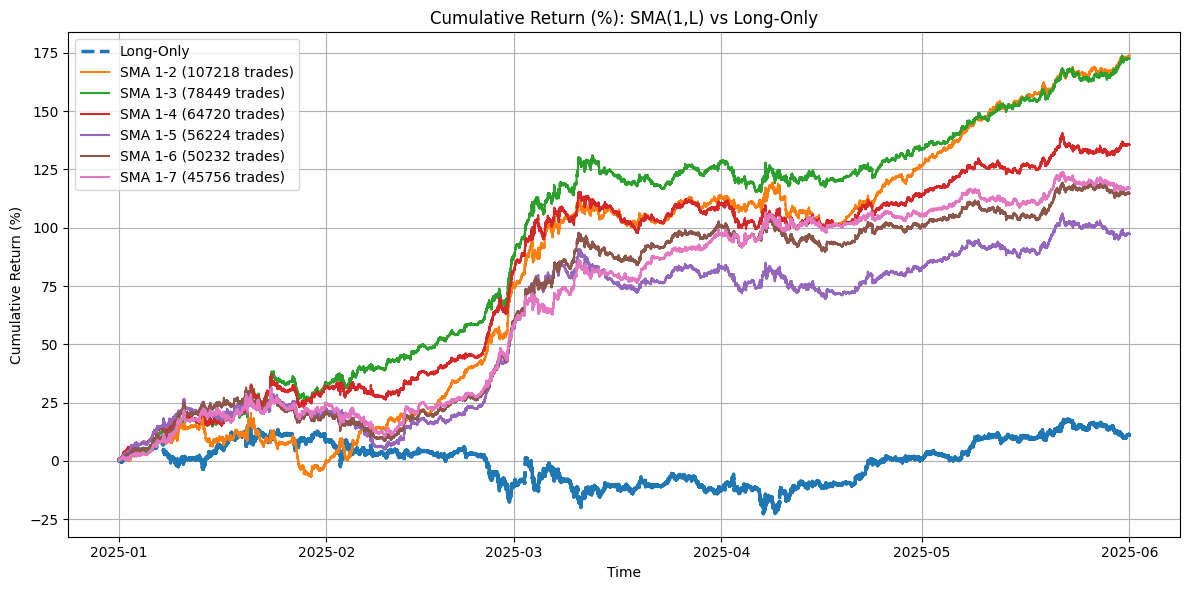


Final Return Summary (%):
Strategy   Final Return    Trade Count     Return/Trade
Long-Only         11.09              1            11.09
1-2              173.96         107218             0.00
1-3              172.58          78449             0.00
1-4              135.59          64720             0.00
1-5               97.39          56224             0.00
1-6              114.75          50232             0.00
1-7              117.02          45756             0.00


In [41]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

cumulative_returns = {}
trade_counts = {}

# Long-only benchmark
long_only_return = df["return"].cumsum()
long_only_label = "Long-Only"
cumulative_returns[long_only_label] = long_only_return
trade_counts[long_only_label] = 1  # Always in position

# SMA(1, L) strategies
for long_win in range(2, 8):
    short_sma = df["sma_1"]
    long_sma = df[f"sma_{long_win}"]

    signal = np.where(short_sma > long_sma, 1, -1)
    shifted_signal = pd.Series(signal, index=df.index).shift(1)

    strategy_return = shifted_signal * df["return"]
    cumulative_return = strategy_return.cumsum()
    cumulative_returns[f"1-{long_win}"] = cumulative_return

    signal_changes = pd.Series(signal, index=df.index).diff().fillna(0)
    trade_count = (signal_changes != 0).sum()
    trade_counts[f"1-{long_win}"] = trade_count

# Plot returns
plt.figure(figsize=(12, 6))
for label, curve in cumulative_returns.items():
    if label == long_only_label:
        plt.plot(curve.index, curve * 100, label=label, linewidth=2.5, linestyle='--')
    else:
        plt.plot(curve.index, curve * 100, label=f"SMA {label} ({trade_counts[label]} trades)")

plt.title("Cumulative Return (%): SMA(1,L) vs Long-Only")
plt.xlabel("Time")
plt.ylabel("Cumulative Return (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print stats
print("\nFinal Return Summary (%):")
print("{:<10} {:>12} {:>14} {:>16}".format("Strategy", "Final Return", "Trade Count", "Return/Trade"))
for label in cumulative_returns:
    final_ret = cumulative_returns[label].iloc[-1] * 100
    trades = trade_counts[label]
    ret_per_trade = final_ret / trades if trades > 0 else np.nan
    print(f"{label:<10} {final_ret:12.2f} {trades:14} {ret_per_trade:16.2f}")
print(f"Choose 1-3.")


In [20]:
# ROC windows and results
roc_windows = list(range(1, 301, 1))
roc_combinations = [(s, l) for s, l in product(roc_windows, roc_windows) if s < l]

# Precompute ROC columns
for win in roc_windows:
    df[f"roc_{win}"] = df["close"].pct_change(periods=win)

roc_results = []

for short_win, long_win in tqdm(roc_combinations, desc="Testing ROC pairs"):
    short_roc = df[f"roc_{short_win}"]
    long_roc = df[f"roc_{long_win}"]

    signal = np.where(short_roc > long_roc, 1, -1)
    shifted_signal = pd.Series(signal, index=df.index).shift(1)

    strategy_return = shifted_signal * df["return"]
    cumulative_return = strategy_return.cumsum().iloc[-1]
    sharpe = strategy_return.mean() / strategy_return.std() * np.sqrt(1440)

    roc_results.append({
        "short": short_win,
        "long": long_win,
        "cumulative_return": cumulative_return,
        "sharpe": sharpe,
    })

# Convert to DataFrame and sort
roc_result_df = pd.DataFrame(roc_results)
roc_result_df.sort_values(by="cumulative_return", ascending=False, inplace=True)

print("\nTop 10 ROC strategies by cumulative return:")
print(roc_result_df.head(10))


C:\Users\wweih\AppData\Local\Temp\ipykernel_1280\269418022.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"roc_{win}"] = df["close"].pct_change(periods=win)
C:\Users\wweih\AppData\Local\Temp\ipykernel_1280\269418022.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"roc_{win}"] = df["close"].pct_change(periods=win)
C:\Users\wweih\AppData\Local\Temp\ipykernel_1280\269418022.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perf


Top 10 ROC strategies by cumulative return:
      short  long  cumulative_return    sharpe
1193      5     9           1.685104  0.402251
602       3     9           1.523815  0.363746
305       2     9           1.503033  0.358785
1487      6     9           1.439391  0.343592
300       2     4           1.401346  0.334509
299       2     3           1.375245  0.328278
5         1     7           1.374611  0.328127
7         1     9           1.352436  0.322833
1         1     3           1.345575  0.321196
302       2     6           1.329496  0.317357


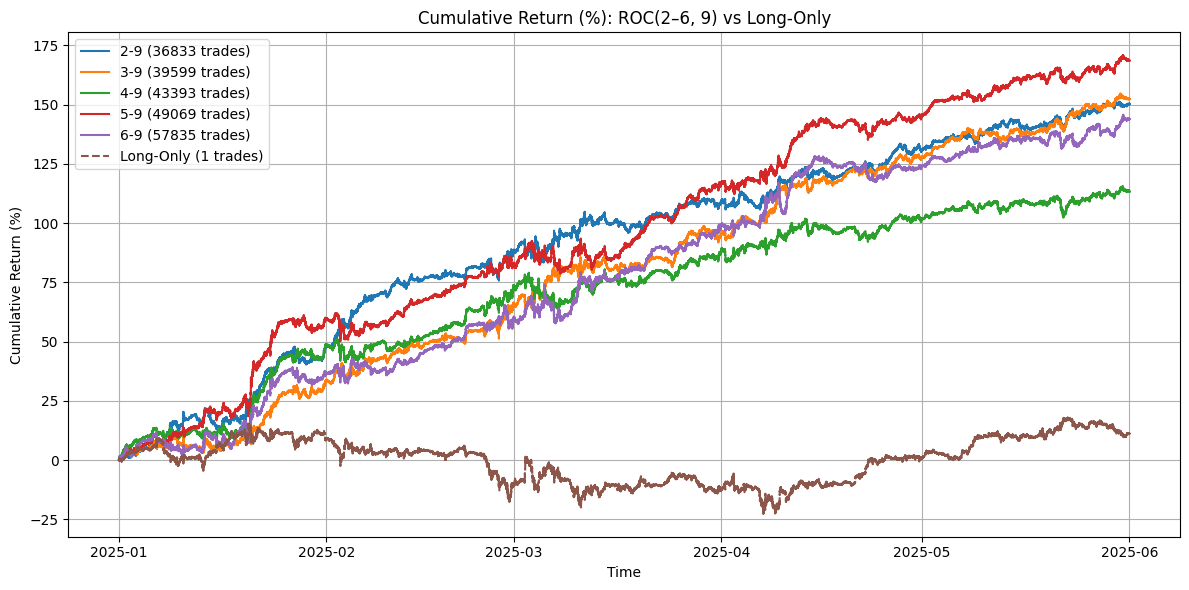


Final Return Summary (%):
Strategy   Final Return    Trade Count     Return/Trade
2-9              150.30          36833             0.00
3-9              152.38          39599             0.00
4-9              113.24          43393             0.00
5-9              168.51          49069             0.00
6-9              143.94          57835             0.00
Long-Only         11.09              1            11.09


In [42]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

roc_short_windows = list(range(2, 7))
roc_long = 9

# Precompute necessary ROC columns
for win in roc_short_windows + [roc_long]:
    df[f"roc_{win}"] = df["close"].pct_change(periods=win)

cumulative_returns_roc = {}
trade_counts_roc = {}

# Compute ROC signals
for short_win in roc_short_windows:
    short_roc = df[f"roc_{short_win}"]
    long_roc = df[f"roc_{roc_long}"]
    signal = np.where(short_roc > long_roc, 1, -1)
    shifted_signal = pd.Series(signal, index=df.index).shift(1)
    strategy_return = shifted_signal * df["return"]
    cumulative_return = strategy_return.cumsum()

    label = f"{short_win}-{roc_long}"
    cumulative_returns_roc[label] = cumulative_return
    trade_counts_roc[label] = (pd.Series(signal).diff().fillna(0) != 0).sum()

# Add long-only benchmark
cumulative_returns_roc["Long-Only"] = df["return"].cumsum()
trade_counts_roc["Long-Only"] = 1

# Plot
plt.figure(figsize=(12, 6))
for label, cumret in cumulative_returns_roc.items():
    style = '--' if label == "Long-Only" else '-'
    plt.plot(cumret.index, cumret * 100, label=f"{label} ({trade_counts_roc[label]} trades)", linestyle=style)

plt.title("Cumulative Return (%): ROC(2–6, 9) vs Long-Only")
plt.xlabel("Time")
plt.ylabel("Cumulative Return (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Summary Table
print("\nFinal Return Summary (%):")
print("{:<10} {:>12} {:>14} {:>16}".format("Strategy", "Final Return", "Trade Count", "Return/Trade"))
for label, curve in cumulative_returns_roc.items():
    final_ret = curve.iloc[-1] * 100
    trades = trade_counts_roc[label]
    print(f"{label:<10} {final_ret:12.2f} {trades:14} {final_ret / trades:16.2f}")

print(f"Choose 2-9.")


In [21]:
# EMA windows and combinations
ema_windows = list(range(1, 301, 1))
ema_combinations = [(s, l) for s, l in product(ema_windows, ema_windows) if s < l]

# Precompute all EMA columns
for win in ema_windows:
    df[f"ema_{win}"] = df["close"].ewm(span=win, adjust=False).mean()

ema_results = []

for short_win, long_win in tqdm(ema_combinations, desc="Testing EMA pairs"):
    short_ema = df[f"ema_{short_win}"]
    long_ema = df[f"ema_{long_win}"]

    signal = np.where(short_ema > long_ema, 1, -1)
    shifted_signal = pd.Series(signal, index=df.index).shift(1)

    strategy_return = shifted_signal * df["return"]
    cumulative_return = strategy_return.cumsum().iloc[-1]
    sharpe = strategy_return.mean() / strategy_return.std() * np.sqrt(1440)

    ema_results.append({
        "short": short_win,
        "long": long_win,
        "cumulative_return": cumulative_return,
        "sharpe": sharpe,
    })

# Convert to DataFrame and sort
ema_result_df = pd.DataFrame(ema_results)
ema_result_df.sort_values(by="cumulative_return", ascending=False, inplace=True)

print("\nTop 10 EMA strategies by cumulative return:")
print(ema_result_df.head(10))


C:\Users\wweih\AppData\Local\Temp\ipykernel_1280\1473891163.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"ema_{win}"] = df["close"].ewm(span=win, adjust=False).mean()
C:\Users\wweih\AppData\Local\Temp\ipykernel_1280\1473891163.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"ema_{win}"] = df["close"].ewm(span=win, adjust=False).mean()
C:\Users\wweih\AppData\Local\Temp\ipykernel_1280\1473891163.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many t


Top 10 EMA strategies by cumulative return:
     short  long  cumulative_return    sharpe
0        1     2           1.673628  0.399511
1        1     3           1.437736  0.343197
2        1     4           1.237229  0.295331
299      2     3           0.973046  0.232267
5        1     7           0.936243  0.223482
301      2     5           0.905666  0.216183
4        1     6           0.904132  0.215817
3        1     5           0.899665  0.214750
300      2     4           0.885336  0.211330
6        1     8           0.798422  0.190583


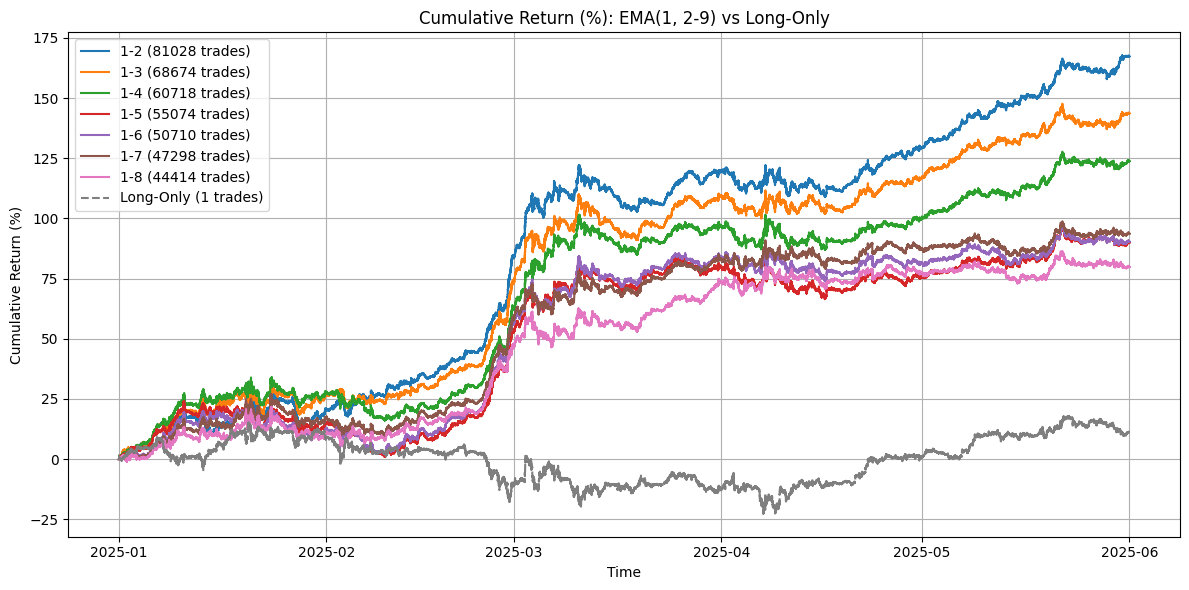


Final Return Summary (%):
Strategy   Final Return    Trade Count     Return/Trade
1-2              167.36          81028             0.00
1-3              143.77          68674             0.00
1-4              123.72          60718             0.00
1-5               89.97          55074             0.00
1-6               90.41          50710             0.00
1-7               93.62          47298             0.00
1-8               79.84          44414             0.00
Long-Only         11.09              1            11.09


In [43]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Make sure df has "return" column
if "return" not in df.columns:
    df["return"] = np.log(df["close"] / df["close"].shift(1))

ema_short = 1
ema_longs = list(range(2, 9))

# Precompute EMA columns
for win in [ema_short] + ema_longs:
    df[f"ema_{win}"] = df["close"].ewm(span=win, adjust=False).mean()

cumulative_returns_ema = {}
trade_counts_ema = {}

for long_win in ema_longs:
    short_ema = df[f"ema_{ema_short}"]
    long_ema = df[f"ema_{long_win}"]

    signal = np.where(short_ema > long_ema, 1, -1)
    shifted_signal = pd.Series(signal, index=df.index).shift(1)

    strategy_return = shifted_signal * df["return"]
    cumulative_return = strategy_return.cumsum()
    cumulative_returns_ema[f"{ema_short}-{long_win}"] = cumulative_return

    # Count trades = signal changes
    signal_series = pd.Series(signal, index=df.index)
    trade_count = (signal_series.diff().fillna(0) != 0).sum()
    trade_counts_ema[f"{ema_short}-{long_win}"] = trade_count

# Long-only baseline
cumulative_returns_ema["Long-Only"] = df["return"].cumsum()
trade_counts_ema["Long-Only"] = 1

# Plot results
plt.figure(figsize=(12, 6))
for label, cumret in cumulative_returns_ema.items():
    style = '--' if label == "Long-Only" else '-'
    plt.plot(cumret.index, cumret * 100, label=f"{label} ({trade_counts_ema[label]} trades)", linestyle=style)

plt.title("Cumulative Return (%): EMA(1, 2-9) vs Long-Only")
plt.xlabel("Time")
plt.ylabel("Cumulative Return (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print summary table
print("\nFinal Return Summary (%):")
print("{:<10} {:>12} {:>14} {:>16}".format("Strategy", "Final Return", "Trade Count", "Return/Trade"))
for label, curve in cumulative_returns_ema.items():
    final_ret = curve.iloc[-1] * 100
    trades = trade_counts_ema[label]
    print(f"{label:<10} {final_ret:12.2f} {trades:14} {final_ret / trades:16.2f}")
print(f"Choose 1-3.")


In [32]:
from itertools import product
from tqdm import tqdm
import pandas as pd
import numpy as np

# Define RSI windows and combinations
rsi_windows = list(range(2, 301))
rsi_combinations = [(s, l) for s, l in product(rsi_windows, rsi_windows) if s < l]

# Precompute price differences
delta = df['close'].diff()
gain = np.where(delta > 0, delta, 0.0)
loss = np.where(delta < 0, -delta, 0.0)
gain_series = pd.Series(gain, index=df.index)
loss_series = pd.Series(loss, index=df.index)
for win in rsi_windows:
    avg_gain = gain_series.ewm(span=win, adjust=False).mean()
    avg_loss = loss_series.ewm(span=win, adjust=False).mean()
    rs = avg_gain / avg_loss
    rs = rs.replace([np.inf, -np.inf], np.nan).fillna(0)
    df[f"rsi_{win}"] = 100 - (100 / (1 + rs))

# RSI crossover backtest
rsi_results = []

for short_win, long_win in tqdm(rsi_combinations, desc="Testing RSI crossover pairs"):
    short_rsi = df[f"rsi_{short_win}"]
    long_rsi = df[f"rsi_{long_win}"]

    signal = np.where((short_rsi > long_rsi) & (short_rsi.shift(1) <= long_rsi.shift(1)), 1,
                      np.where((short_rsi < long_rsi) & (short_rsi.shift(1) >= long_rsi.shift(1)), -1, 0))

    shifted_signal = pd.Series(signal, index=df.index).shift(1)
    strategy_return = shifted_signal * df["return"]

    cumulative_return = strategy_return.cumsum().iloc[-1]
    sharpe = strategy_return.mean() / strategy_return.std() * np.sqrt(1440)

    rsi_results.append({
        "short": short_win,
        "long": long_win,
        "cumulative_return": cumulative_return,
        "sharpe": sharpe,
    })

# Convert to DataFrame and sort
rsi_result_df = pd.DataFrame(rsi_results)
rsi_result_df.sort_values(by="cumulative_return", ascending=False, inplace=True)

print("\nTop 10 RSI crossover strategies by cumulative return:")
print(rsi_result_df.head(10))


Testing RSI crossover pairs: 100%|██████████| 44551/44551 [07:58<00:00, 93.12it/s] 


Top 10 RSI crossover strategies by cumulative return:
    short  long  cumulative_return    sharpe
21      2    24           1.409269  0.541299
22      2    25           1.403012  0.539294
18      2    21           1.402062  0.537421
20      2    23           1.393045  0.534834
19      2    22           1.389684  0.533058
23      2    26           1.375570  0.528572
17      2    20           1.371727  0.525935
15      2    18           1.356946  0.519737
16      2    19           1.350624  0.517614
14      2    17           1.344348  0.514067


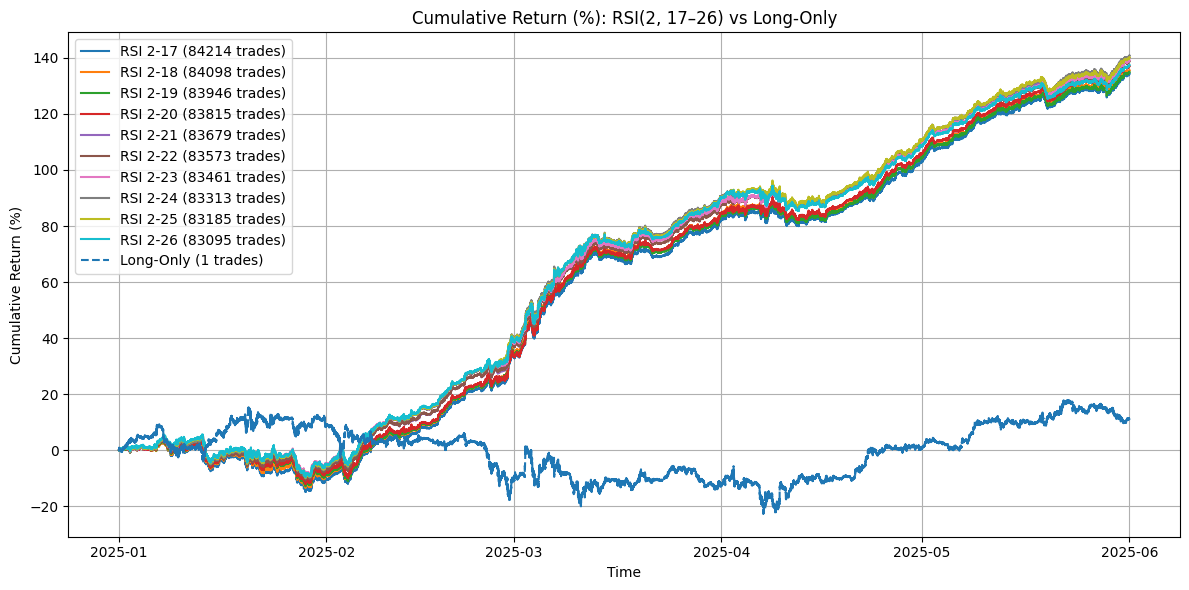


Final Return Summary (%):
Strategy           Final Return    Trade Count     Return/Trade
RSI 2-17                 134.43          84214             0.00
RSI 2-18                 135.69          84098             0.00
RSI 2-19                 135.06          83946             0.00
RSI 2-20                 137.17          83815             0.00
RSI 2-21                 140.21          83679             0.00
RSI 2-22                 138.97          83573             0.00
RSI 2-23                 139.30          83461             0.00
RSI 2-24                 140.93          83313             0.00
RSI 2-25                 140.30          83185             0.00
RSI 2-26                 137.56          83095             0.00
Long-Only                 11.09              1            11.09


In [44]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Make sure 'return' column exists
if "return" not in df.columns:
    df["return"] = np.log(df["close"] / df["close"].shift(1))

short_win = 2
long_windows = list(range(17, 27))

# Precompute RSI for short and long windows
delta = df['close'].diff()
gain = np.where(delta > 0, delta, 0.0)
loss = np.where(delta < 0, -delta, 0.0)
gain_series = pd.Series(gain, index=df.index)
loss_series = pd.Series(loss, index=df.index)

for win in [short_win] + long_windows:
    avg_gain = gain_series.ewm(span=win, adjust=False).mean()
    avg_loss = loss_series.ewm(span=win, adjust=False).mean()
    rs = avg_gain / avg_loss
    rs = rs.replace([np.inf, -np.inf], np.nan).fillna(0)
    df[f"rsi_{win}"] = 100 - (100 / (1 + rs))

cumulative_returns_rsi = {}
trade_counts_rsi = {}

for long_win in long_windows:
    short_rsi = df[f"rsi_{short_win}"]
    long_rsi = df[f"rsi_{long_win}"]

    signal = np.where(
        (short_rsi > long_rsi) & (short_rsi.shift(1) <= long_rsi.shift(1)), 1,
        np.where(
            (short_rsi < long_rsi) & (short_rsi.shift(1) >= long_rsi.shift(1)), -1, 0
        )
    )
    shifted_signal = pd.Series(signal, index=df.index).shift(1)

    strategy_return = shifted_signal * df["return"]
    cumulative_return = strategy_return.cumsum()

    label = f"RSI {short_win}-{long_win}"
    cumulative_returns_rsi[label] = cumulative_return

    # Count trades as changes in signal excluding zero signals
    signal_series = pd.Series(signal, index=df.index)
    trades = ((signal_series.diff().fillna(0) != 0) & (signal_series != 0)).sum()
    trade_counts_rsi[label] = trades

# Add long-only baseline
cumulative_returns_rsi["Long-Only"] = df["return"].cumsum()
trade_counts_rsi["Long-Only"] = 1

# Plot
plt.figure(figsize=(12, 6))
for label, cumret in cumulative_returns_rsi.items():
    style = '--' if label == "Long-Only" else '-'
    plt.plot(cumret.index, cumret * 100, label=f"{label} ({trade_counts_rsi[label]} trades)", linestyle=style)

plt.title("Cumulative Return (%): RSI(2, 17–26) vs Long-Only")
plt.xlabel("Time")
plt.ylabel("Cumulative Return (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print summary table
print("\nFinal Return Summary (%):")
print("{:<15} {:>15} {:>14} {:>16}".format("Strategy", "Final Return", "Trade Count", "Return/Trade"))
for label, curve in cumulative_returns_rsi.items():
    final_ret = curve.iloc[-1] * 100
    trades = trade_counts_rsi[label]
    ret_per_trade = final_ret / trades if trades > 0 else np.nan
    print(f"{label:<15} {final_ret:15.2f} {trades:14} {ret_per_trade:16.2f}")
print("Choose 2-21.")


In [33]:
from tqdm import tqdm
from itertools import product
import pandas as pd
import numpy as np

macd_range = list(range(1, 31, 1))
macd_combinations = [(fast, slow, signal) for fast, slow, signal in product(macd_range, macd_range, macd_range) if fast < slow]

macd_results = []

for fast, slow, signal_len in tqdm(macd_combinations, desc="Testing MACD (1–300)", total=len(macd_combinations)):
    ema_fast = df["close"].ewm(span=fast, adjust=False).mean()
    ema_slow = df["close"].ewm(span=slow, adjust=False).mean()
    macd_line = ema_fast - ema_slow
    signal_line = macd_line.ewm(span=signal_len, adjust=False).mean()

    signal = np.where(macd_line > signal_line, 1, -1)
    shifted_signal = pd.Series(signal, index=df.index).shift(1)
    strategy_return = shifted_signal * df["return"]

    cumulative_return = strategy_return.cumsum().iloc[-1]
    sharpe = strategy_return.mean() / strategy_return.std() * np.sqrt(1440)

    macd_results.append({
        "fast": fast,
        "slow": slow,
        "signal": signal_len,
        "cumulative_return": cumulative_return,
        "sharpe": sharpe,
    })

# Create result DataFrame
macd_result_df = pd.DataFrame(macd_results)
macd_result_df.sort_values(by="cumulative_return", ascending=False, inplace=True)

print("\nTop 10 MACD strategies by cumulative return:")
print(macd_result_df.head(10))


Testing MACD (1–300): 100%|██████████| 13050/13050 [03:48<00:00, 57.07it/s]


Top 10 MACD strategies by cumulative return:
     fast  slow  signal  cumulative_return    sharpe
94      1     5       5           2.102401  0.501880
123     1     6       4           2.082876  0.497218
65      1     4       6           2.082876  0.497218
66      1     4       7           2.079068  0.496309
153     1     7       4           2.079068  0.496309
63      1     4       4           2.046775  0.488599
242     1    10       3           2.042947  0.487685
39      1     3      10           2.042947  0.487685
95      1     5       6           2.040583  0.487120
124     1     6       5           2.040583  0.487120


C:\Users\wweih\AppData\Local\Temp\ipykernel_1280\2914193064.py:51: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
C:\Users\wweih\Documents\School\Market Microstructure\Basic\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


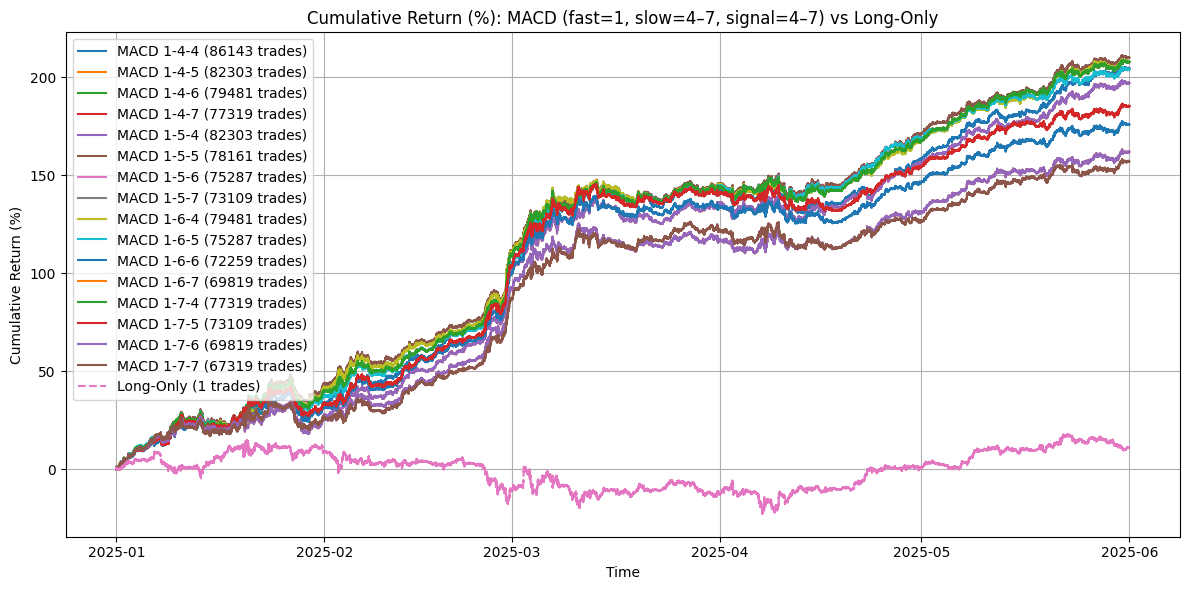


Final Return Summary (%):
Strategy                Final Return    Trade Count     Return/Trade
MACD 1-4-4                    204.68          86143             0.00
MACD 1-4-5                    197.25          82303             0.00
MACD 1-4-6                    208.29          79481             0.00
MACD 1-4-7                    207.91          77319             0.00
MACD 1-5-4                    197.25          82303             0.00
MACD 1-5-5                    210.24          78161             0.00
MACD 1-5-6                    204.06          75287             0.00
MACD 1-5-7                    185.38          73109             0.00
MACD 1-6-4                    208.29          79481             0.00
MACD 1-6-5                    204.06          75287             0.00
MACD 1-6-6                    176.14          72259             0.00
MACD 1-6-7                    162.11          69819             0.00
MACD 1-7-4                    207.91          77319             0.00
MACD 1-

In [45]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Make sure df has 'return' column
if "return" not in df.columns:
    df["return"] = np.log(df["close"] / df["close"].shift(1))

fast = 1
slow_range = list(range(4, 8))
signal_range = list(range(4, 8))

cumulative_returns_macd = {}
trade_counts_macd = {}

for slow in slow_range:
    for signal_len in signal_range:
        ema_fast = df["close"].ewm(span=fast, adjust=False).mean()
        ema_slow = df["close"].ewm(span=slow, adjust=False).mean()
        macd_line = ema_fast - ema_slow
        signal_line = macd_line.ewm(span=signal_len, adjust=False).mean()

        signal = np.where(macd_line > signal_line, 1, -1)
        shifted_signal = pd.Series(signal, index=df.index).shift(1)

        strategy_return = shifted_signal * df["return"]
        cumulative_return = strategy_return.cumsum()

        label = f"MACD {fast}-{slow}-{signal_len}"
        cumulative_returns_macd[label] = cumulative_return

        signal_series = pd.Series(signal, index=df.index)
        trades = (signal_series.diff().fillna(0) != 0).sum()
        trade_counts_macd[label] = trades

# Add long-only baseline
cumulative_returns_macd["Long-Only"] = df["return"].cumsum()
trade_counts_macd["Long-Only"] = 1

# Plot cumulative returns
plt.figure(figsize=(12, 6))
for label, cumret in cumulative_returns_macd.items():
    style = '--' if label == "Long-Only" else '-'
    plt.plot(cumret.index, cumret * 100, label=f"{label} ({trade_counts_macd[label]} trades)", linestyle=style)

plt.title("Cumulative Return (%): MACD (fast=1, slow=4–7, signal=4–7) vs Long-Only")
plt.xlabel("Time")
plt.ylabel("Cumulative Return (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print summary table
print("\nFinal Return Summary (%):")
print("{:<20} {:>15} {:>14} {:>16}".format("Strategy", "Final Return", "Trade Count", "Return/Trade"))
for label, curve in cumulative_returns_macd.items():
    final_ret = curve.iloc[-1] * 100
    trades = trade_counts_macd[label]
    ret_per_trade = final_ret / trades if trades > 0 else float('nan')
    print(f"{label:<20} {final_ret:15.2f} {trades:14} {ret_per_trade:16.2f}")
print("Choose 1-5-5.")


In [36]:
from tqdm import tqdm
from itertools import product
import pandas as pd
import numpy as np

# Define ranges for window size and number of std deviations
bb_windows = list(range(1, 300, 1))          # e.g. 10, 15, ..., 100
bb_stddevs = list(np.arange(0.1, 1.3, 0.1))                 # 1, 2, 3 standard deviations

bb_combinations = [(win, stddev) for win, stddev in product(bb_windows, bb_stddevs)]

bb_results = []

for window, stddev in tqdm(bb_combinations, desc="Testing Bollinger Bands", total=len(bb_combinations)):
    sma = df["close"].rolling(window=window).mean()
    std = df["close"].rolling(window=window).std()

    upper = sma + stddev * std
    lower = sma - stddev * std

    # Mean reversion style signals:
    # Buy when price < lower band, sell when price > upper band
    signal = np.where(df["close"] < lower, -1, np.where(df["close"] > upper, 1, 0))
    shifted_signal = pd.Series(signal, index=df.index).shift(1)

    strategy_return = shifted_signal * df["return"]

    cumulative_return = strategy_return.cumsum().iloc[-1]
    sharpe = strategy_return.mean() / strategy_return.std() * np.sqrt(1440)

    bb_results.append({
        "window": window,
        "stddev": stddev,
        "cumulative_return": cumulative_return,
        "sharpe": sharpe,
    })

bb_result_df = pd.DataFrame(bb_results)
bb_result_df.sort_values(by="cumulative_return", ascending=False, inplace=True)

print("\nTop 10 Bollinger Bands strategies by cumulative return:")
print(bb_result_df.head(10))


Testing Bollinger Bands:   0%|          | 0/3588 [00:00<?, ?it/s]C:\Users\wweih\AppData\Local\Temp\ipykernel_1280\3738128068.py:29: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = strategy_return.mean() / strategy_return.std() * np.sqrt(1440)
Testing Bollinger Bands: 100%|██████████| 3588/3588 [01:11<00:00, 50.36it/s]


Top 10 Bollinger Bands strategies by cumulative return:
    window  stddev  cumulative_return    sharpe
12       2     0.1           1.722792  0.411972
13       2     0.2           1.722792  0.411972
15       2     0.4           1.722696  0.412124
14       2     0.3           1.720815  0.411635
16       2     0.5           1.712765  0.409815
17       2     0.6           1.704632  0.407921
18       2     0.7           1.696437  0.406103
25       3     0.2           1.659195  0.412427
24       3     0.1           1.620890  0.394001
26       3     0.3           1.540847  0.391798


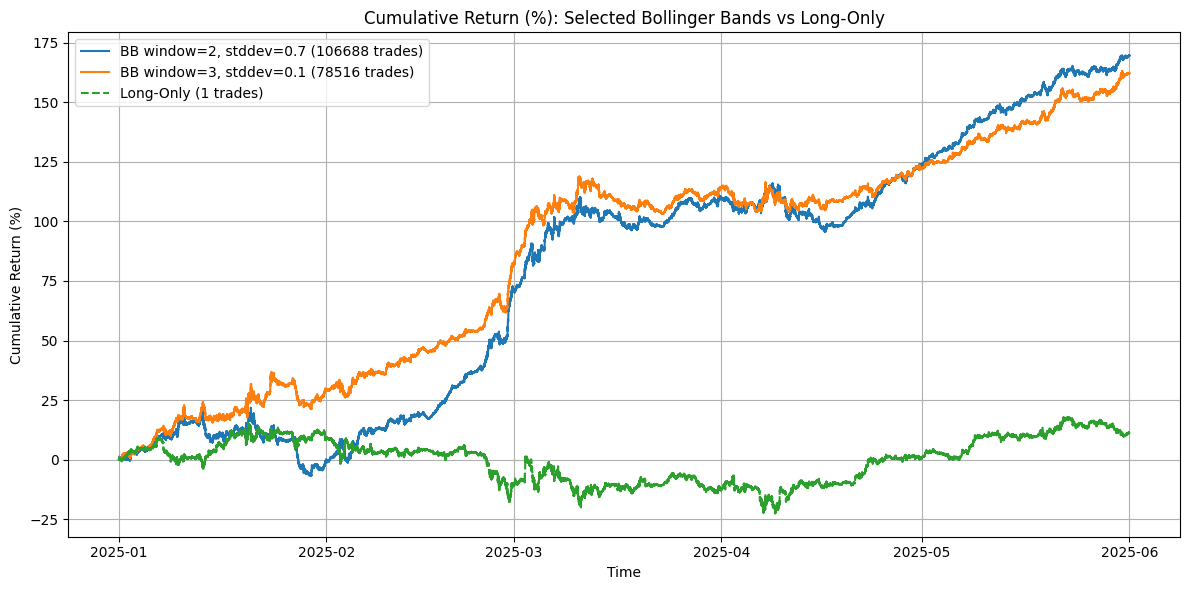


Final Return Summary (%):
Strategy                          Final Return    Trade Count     Return/Trade
BB window=2, stddev=0.7                 169.64         106688             0.00
BB window=3, stddev=0.1                 162.09          78516             0.00
Long-Only                                11.09              1            11.09


In [50]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Ensure returns column exists
if "return" not in df.columns:
    df["return"] = np.log(df["close"] / df["close"].shift(1))

bb_params = [
    (2, 0.7),
    (3, 0.1),
]

cumulative_returns_bb = {}
trade_counts_bb = {}

for window, stddev in bb_params:
    sma = df["close"].rolling(window=window).mean()
    std = df["close"].rolling(window=window).std()

    upper = sma + stddev * std
    lower = sma - stddev * std

    signal = np.where(df["close"] < lower, -1,
                      np.where(df["close"] > upper, 1, 0))
    shifted_signal = pd.Series(signal, index=df.index).shift(1)

    strategy_return = shifted_signal * df["return"]
    cumulative_return = strategy_return.cumsum()

    label = f"BB window={window}, stddev={stddev:.1f}"
    cumulative_returns_bb[label] = cumulative_return

    signal_series = pd.Series(signal, index=df.index)
    trades = ((signal_series.diff().fillna(0) != 0) & (signal_series != 0)).sum()
    trade_counts_bb[label] = trades

# Long-only baseline
cumulative_returns_bb["Long-Only"] = df["return"].cumsum()
trade_counts_bb["Long-Only"] = 1

# Plot cumulative returns (%)
plt.figure(figsize=(12, 6))
for label, cumret in cumulative_returns_bb.items():
    style = '--' if label == "Long-Only" else '-'
    plt.plot(cumret.index, cumret * 100, label=f"{label} ({trade_counts_bb[label]} trades)", linestyle=style)

plt.title("Cumulative Return (%): Selected Bollinger Bands vs Long-Only")
plt.xlabel("Time")
plt.ylabel("Cumulative Return (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Summary table
print("\nFinal Return Summary (%):")
print("{:<30} {:>15} {:>14} {:>16}".format("Strategy", "Final Return", "Trade Count", "Return/Trade"))
for label, curve in cumulative_returns_bb.items():
    final_ret = curve.iloc[-1] * 100
    trades = trade_counts_bb[label]
    ret_per_trade = final_ret / trades if trades > 0 else float('nan')
    print(f"{label:<30} {final_ret:15.2f} {trades:14} {ret_per_trade:16.2f}")

print("Choose 3-0.1.")


In [35]:
from tqdm import tqdm
import numpy as np
import pandas as pd
from itertools import product

momentum_windows = [51]
volume_periods = list(range(80, 111, 1))

momentum_results = []

for mom_win, vol_win in tqdm(product(momentum_windows, volume_periods), total=len(momentum_windows)*len(volume_periods), desc="Testing Momentum+Volume with Confidence"):
    momentum = df["close"].diff(periods=mom_win)
    avg_volume = df["volume"].rolling(window=vol_win).mean()
    current_volume = df["volume"]

    volume_conf = current_volume / avg_volume
    volume_conf = volume_conf.fillna(0)

    signal = np.where(
        (momentum > 0) & (volume_conf > 1.0), -1,
        np.where(
            (momentum < 0) & (volume_conf > 1.0), 1,
            0
        )
    )

    confidence = np.minimum(volume_conf, 2.0) / 2.0
    confidence[signal == 0] = 0

    shifted_signal = pd.Series(signal, index=df.index).shift(1)
    shifted_confidence = pd.Series(confidence, index=df.index).shift(1)

    strategy_return = shifted_signal * shifted_confidence * df["return"]

    cumulative_return = strategy_return.cumsum().iloc[-1]
    sharpe = strategy_return.mean() / strategy_return.std() * np.sqrt(1440)

    momentum_results.append({
        "type": "momentum_volume_confidence",
        "momentum_window": mom_win,
        "volume_period": vol_win,
        "cumulative_return": cumulative_return,
        "sharpe": sharpe,
    })

momentum_df = pd.DataFrame(momentum_results)
momentum_df.sort_values(by="cumulative_return", ascending=False, inplace=True)

print("\nTop 10 Momentum+Volume (with confidence) strategies by cumulative return:")
print(momentum_df.head(10))


Testing Momentum+Volume with Confidence: 100%|██████████| 31/31 [00:00<00:00, 53.17it/s]


Top 10 Momentum+Volume (with confidence) strategies by cumulative return:
                          type  momentum_window  volume_period  \
6   momentum_volume_confidence               51             86   
13  momentum_volume_confidence               51             93   
25  momentum_volume_confidence               51            105   
7   momentum_volume_confidence               51             87   
5   momentum_volume_confidence               51             85   
14  momentum_volume_confidence               51             94   
12  momentum_volume_confidence               51             92   
26  momentum_volume_confidence               51            106   
11  momentum_volume_confidence               51             91   
10  momentum_volume_confidence               51             90   

    cumulative_return    sharpe  
6            0.637124  0.252762  
13           0.634858  0.250471  
25           0.632175  0.247012  
7            0.631692  0.250373  
5            0.629165  0.249

Testing Momentum+Volume with Confidence: 100%|██████████| 5/5 [00:00<00:00, 31.79it/s]


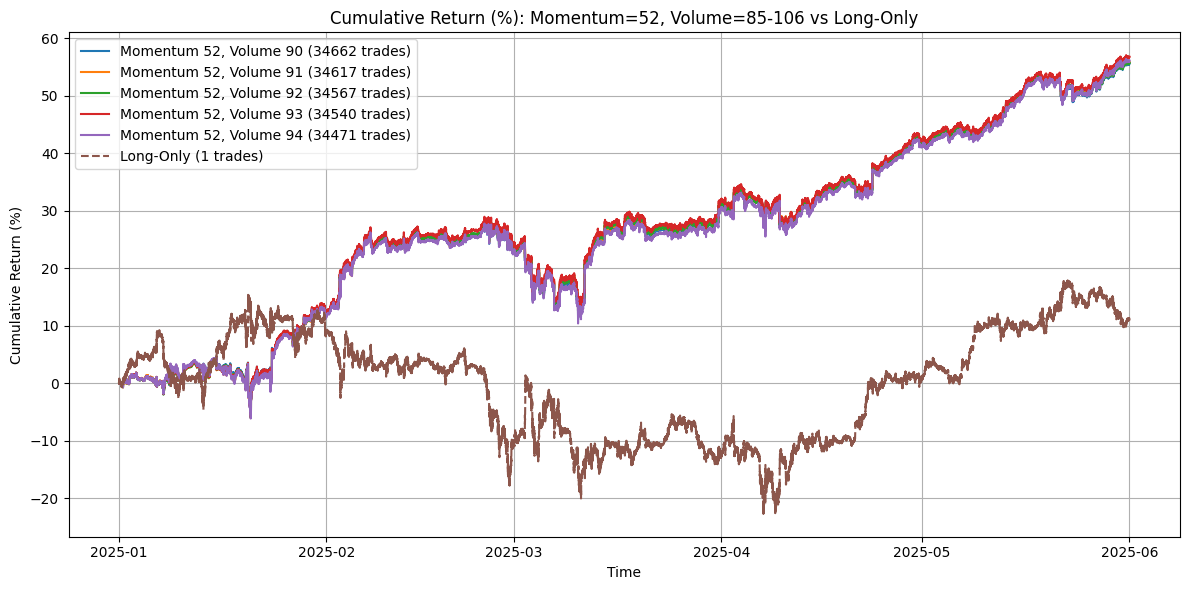


Final Return Summary (%):
Strategy                          Final Return    Trade Count     Return/Trade
Momentum 52, Volume 90                   55.64          34662             0.00
Momentum 52, Volume 91                   55.91          34617             0.00
Momentum 52, Volume 92                   55.75          34567             0.00
Momentum 52, Volume 93                   56.83          34540             0.00
Momentum 52, Volume 94                   56.15          34471             0.00
Long-Only                                11.09              1            11.09
Choose 51-93.


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

momentum_window = 52
volume_periods = list(range(90, 95))  # 85 to 106 inclusive

cumulative_returns_mv = {}
trade_counts_mv = {}

for vol_win in tqdm(volume_periods, desc="Testing Momentum+Volume with Confidence"):
    momentum = df["close"].diff(periods=momentum_window)
    avg_volume = df["volume"].rolling(window=vol_win).mean()
    current_volume = df["volume"]

    volume_conf = current_volume / avg_volume
    volume_conf = volume_conf.fillna(0)

    signal = np.where(
        (momentum > 0) & (volume_conf > 1.0), -1,
        np.where(
            (momentum < 0) & (volume_conf > 1.0), 1,
            0
        )
    )

    confidence = np.minimum(volume_conf, 2.0) / 2.0
    confidence[signal == 0] = 0

    shifted_signal = pd.Series(signal, index=df.index).shift(1)
    shifted_confidence = pd.Series(confidence, index=df.index).shift(1)

    strategy_return = shifted_signal * shifted_confidence * df["return"]
    cumulative_return = strategy_return.cumsum()

    label = f"Momentum {momentum_window}, Volume {vol_win}"
    cumulative_returns_mv[label] = cumulative_return

    signal_series = pd.Series(signal, index=df.index)
    # Count trades as signal changes where signal != 0
    trades = ((signal_series.diff().fillna(0) != 0) & (signal_series != 0)).sum()
    trade_counts_mv[label] = trades

# Long-only baseline
cumulative_returns_mv["Long-Only"] = df["return"].cumsum()
trade_counts_mv["Long-Only"] = 1

# Plot cumulative returns (%)
plt.figure(figsize=(12, 6))
for label, cumret in cumulative_returns_mv.items():
    style = '--' if label == "Long-Only" else '-'
    plt.plot(cumret.index, cumret * 100, label=f"{label} ({trade_counts_mv[label]} trades)", linestyle=style)

plt.title(f"Cumulative Return (%): Momentum={momentum_window}, Volume=85-106 vs Long-Only")
plt.xlabel("Time")
plt.ylabel("Cumulative Return (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Summary table
print("\nFinal Return Summary (%):")
print("{:<30} {:>15} {:>14} {:>16}".format("Strategy", "Final Return", "Trade Count", "Return/Trade"))
for label, curve in cumulative_returns_mv.items():
    final_ret = curve.iloc[-1] * 100
    trades = trade_counts_mv[label]
    ret_per_trade = final_ret / trades if trades > 0 else float('nan')
    print(f"{label:<30} {final_ret:15.2f} {trades:14} {ret_per_trade:16.2f}")
print(f"Choose 51-93.")


In [ ]:
from analytics.MOMENTUM import (
    sma_crossover_strategy,
    roc_crossover_strategy,
    ema_crossover_strategy,
    macd_crossover_strategy,
    rsi_crossover_strategy,
    bollinger_band_strategy,
    momentum_volume_strategy,
)

from analytics.AGGREGATOR import aggregate_signals
from tqdm import tqdm
import pandas as pd
from collections import deque

lookback = 150  # Number of candles each strategy needs
initial_balance = 10000
balance = initial_balance
position = 0  # +1 for long, -1 for short, 0 for flat
entry_price = None

# Strategy list and weights
strategies = [
    sma_crossover_strategy,
    roc_crossover_strategy,
    ema_crossover_strategy,
    macd_crossover_strategy,
    rsi_crossover_strategy,
    bollinger_band_strategy,
    momentum_volume_strategy,
]

# Store equity curve
equity_curve = []
df["timestamp"] = pd.to_datetime(df["timestamp"])
last_timestamp = df["timestamp"].max()
start_date = last_timestamp - pd.DateOffset(days=30)
df = df[df["timestamp"] >= start_date].reset_index(drop=True)

# Candle window
window = deque(maxlen=lookback)

for idx in tqdm(range(len(df)), desc="Backtesting", ncols=100):
    candle = df.iloc[idx].to_dict()
    window.append(candle)

    if len(window) < lookback:
        equity_curve.append(balance)
        continue

    signal_data = aggregate_signals(window, strategies)
    signal = signal_data["signal"]
    price = candle["close"]

    # Simulate trade
    if position == 0:
        if signal == "buy":
            position = 1
            entry_price = price
        elif signal == "sell":
            position = -1
            entry_price = price

    elif position == 1:
        if signal == "sell":
            pnl = (price - entry_price)
            balance += pnl
            position = -1
            entry_price = price
        elif signal == "hold":
            pass  # hold long

    elif position == -1:
        if signal == "buy":
            pnl = (entry_price - price)
            balance += pnl
            position = 1
            entry_price = price
        elif signal == "hold":
            pass  # hold short

    equity_curve.append(balance)

# Convert equity to DataFrame
results = pd.DataFrame({
    "timestamp": df["timestamp"],
    "equity": equity_curve
})

results.set_index("timestamp", inplace=True)

# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(results["equity"], label="Equity Curve")
plt.title("Backtest Equity Curve")
plt.xlabel("Time")
plt.ylabel("Balance")
plt.legend()
plt.grid()
plt.show()

Backtesting:   0%|                                           | 139/217440 [00:00<02:36, 1387.93it/s]